<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S4/ERA_Session_4_Himank_Jain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

RandomApply: Applies the given list of transformations randomly with a probability p. In this case, it applies transforms.CenterCrop(22) with a probability of 0.1.

Resize: Resizes the image to a specified size (28, 28).

RandomRotation: Rotates the image randomly within the specified angle range (-15 degrees to 15 degrees). The fill parameter indicates the pixel value to be used for filling the empty areas after rotation, and in this case, it's set to 0.

ToTensor: Converts the image to a PyTorch tensor. PyTorch tensors are the basic building blocks of neural networks in PyTorch.

Normalize: Normalizes the tensor by subtracting the mean (0.1307,) and dividing by the standard deviation (0.3081,). This normalization is commonly used to make the input data have zero mean and unit variance, which can aid in the training process.

These transformations are typically applied to training images to introduce variability and enhance the model's ability to generalize to different variations of the input data. It's commonly used in the context of deep learning for image classification tasks.

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 163889732.56it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 46358857.18it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49409106.08it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 972809.52it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

batch_size: This parameter specifies the number of samples in each batch that will be loaded during training or testing. A larger batch size can speed up training but may require more memory.

shuffle: This parameter determines whether to shuffle the dataset during the loading process. When set to True, it shuffles the data for the training loader, ensuring that the model sees the data in a different order during each epoch. For the testing loader, it's set to False to evaluate the model on the original, unshuffled data.

num_workers: This parameter specifies the number of worker processes to use for data loading. Multiple workers can be utilized to load data in parallel, which can significantly speed up the data loading process. Here, it's set to 2.

pin_memory: This parameter is used when transferring data between the CPU and GPU. If True and a GPU is available (torch.cuda.is_available()), it enables the use of pinned memory for faster data transfer. Pinned memory is a type of memory that is directly accessible by the GPU, reducing data transfer overhead. If no GPU is available, it's set to False.

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

512
512


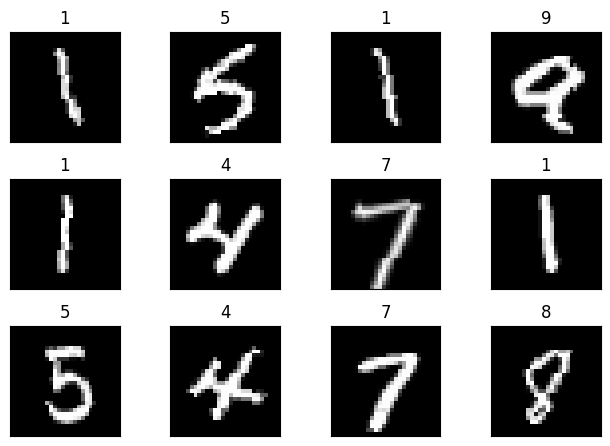

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
print(len(batch_data))
print(len(batch_label))
fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096) # 4*4*256 = 4096
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [ ]:
class Net2(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, bias=False)
        self.fc1 = nn.Linear(4096, 50, bias=False)
        self.fc2 = nn.Linear(50, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096) # 4*4*256 = 4096
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

GetCorrectPredCount Function: This function takes the predicted values (pPrediction) and true labels (pLabels). It calculates the number of correct predictions by comparing the index of the maximum predicted value with the true label index.

train Function: This function performs training on the provided model using the training data. It includes the following steps:

Set the model to training mode (model.train()).
Iterate through the training loader batches using tqdm for progress visualization.
Move data and target to the specified device (CPU or GPU).
Zero out the gradients (optimizer.zero_grad()).
Forward pass: Obtain predictions from the model (model(data)).
Calculate the loss between predictions and true labels.
Backpropagation: Compute gradients and update model parameters (loss.backward() and optimizer.step()).
Update statistics such as training loss, correct predictions, and processed samples.
Display progress information using tqdm.
test Function: This function evaluates the model on the provided test data. It includes the following steps:

Set the model to evaluation mode (model.eval()).
Iterate through the test loader batches.
Move data and target to the specified device.
Forward pass: Obtain predictions from the model.
Calculate the test loss and the number of correct predictions.
Update statistics such as test loss and accuracy.
Print test set information.

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3289 Batch_id=117 Accuracy=41.62: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Test set: Average loss: 0.3814, Accuracy: 8756/10000 (87.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1890 Batch_id=117 Accuracy=92.44: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


Test set: Average loss: 0.1033, Accuracy: 9673/10000 (96.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1851 Batch_id=117 Accuracy=95.67: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


Test set: Average loss: 0.0694, Accuracy: 9785/10000 (97.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0314 Batch_id=117 Accuracy=96.72: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0517, Accuracy: 9830/10000 (98.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0677 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0466, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0233 Batch_id=117 Accuracy=97.69: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0450, Accuracy: 9857/10000 (98.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0394 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:21<00:00,  5.55it/s]


Test set: Average loss: 0.0344, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0427 Batch_id=117 Accuracy=98.15: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0178 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Test set: Average loss: 0.0363, Accuracy: 9883/10000 (98.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0805 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0281, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1073 Batch_id=117 Accuracy=98.51: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0290, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0122 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


Test set: Average loss: 0.0246, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0410 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]


Test set: Average loss: 0.0303, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0730 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0088 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0166 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0101 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0346 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]


Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0080 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


Test set: Average loss: 0.0185, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0103 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

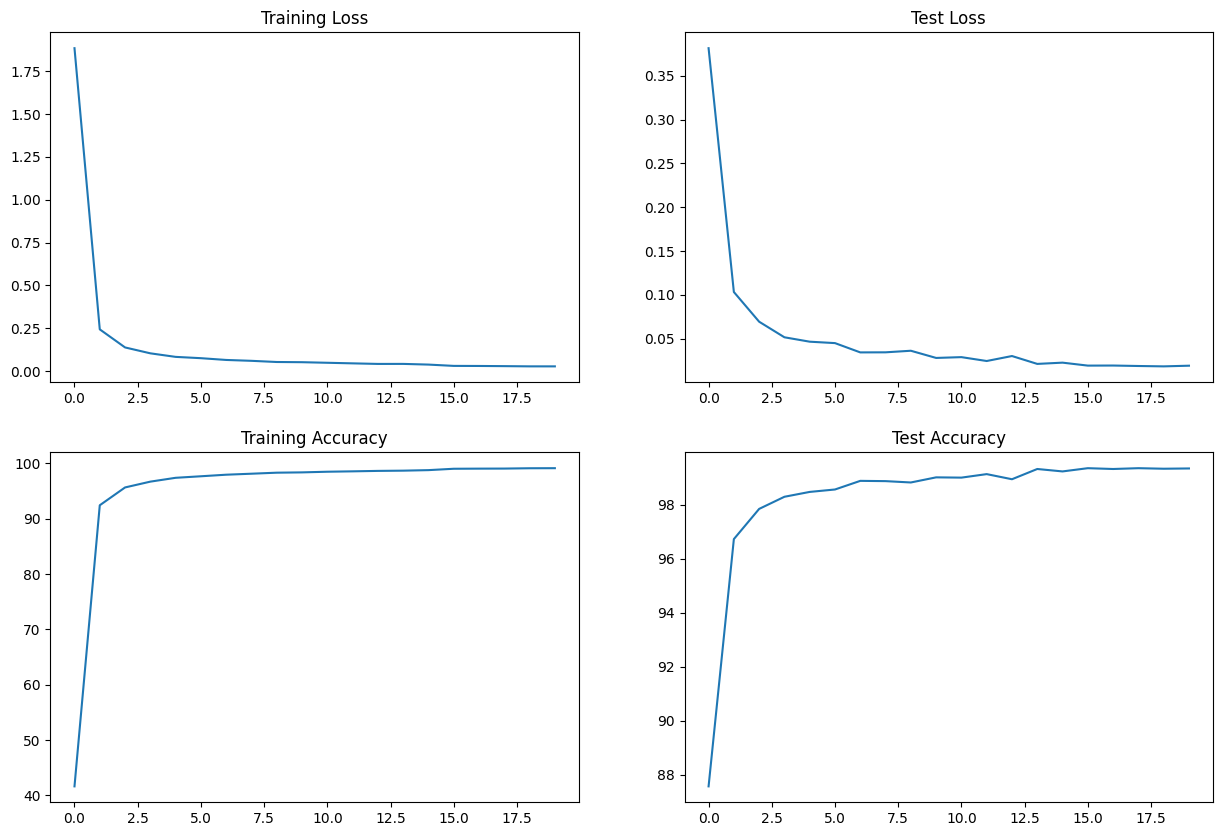

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))